In [2]:
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt
import rosbag
import pandas as pd
from scipy import integrate
from scipy.interpolate import interp1d
from IPython.display import display
from mpldatacursor import datacursor
import time
import math
import cv2
from cv_bridge import CvBridge

In [4]:
#When recording rosbag follow this sequence:
# 1. rosparam set use_sim_time true
# 2. rosbag play XXXXX.bag --clock
# 3. roslaunch darkentros yolov3.launch



filename='2019-02-11-Wentworth-P7-yolo'

bag  = rosbag.Bag('/home/maleen/2019-02-11-Wentworth/yolo/' + filename + '.bag')

In [6]:
encsize=0
yolosize=0

encoder_time=np.array([])
encoder_seq=np.array([])
encoder_x=np.array([])
encoder_y=np.array([])

yolo_time=np.array([])
yolo_seq=np.array([])
image_time=np.array([])
image_seq=np.array([])
bounding_box=[]

detectimg_time=np.array([])
detectimg=np.array([])

foundobj=np.array([])
foundobj_time=np.array([])

imuraw_time=np.array([])
imuraw_seq=np.array([])
imuraw_angaccZ=np.array([])

imureal_time=np.array([])
imureal_seq=np.array([])
imureal_angvZ=np.array([])
imureal_angvX=np.array([])
imureal_angvY=np.array([])

roll=np.array([])
pitch=np.array([])
yaw=np.array([])

topiclist=['/encoder_ticks','/imuraw_ts','/imureal_ts','/wifidata_ts','/darknet_ros/bounding_boxes','/darknet_ros/detection_image', '/darknet_ros/found_object'
]

for topic, msg, t in bag.read_messages(topics=topiclist): #
    
        if topic=='/encoder_ticks':
            
            encoder_time=np.append(encoder_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            encoder_seq=np.append(encoder_seq,msg.header.seq)
            encoder_x=np.append(encoder_x,msg.ticks.x)
            encoder_y=np.append(encoder_y,msg.ticks.y)
            encsize=encsize+1
            
        elif topic=='/darknet_ros/bounding_boxes':
            
            yolo_time=np.append(yolo_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            yolo_seq=np.append(yolo_seq,msg.header.seq)
            
            image_time=np.append(image_time,(msg.image_header.stamp.secs)+(Decimal(msg.image_header.stamp.nsecs)/1000000000))
            image_seq=np.append(image_seq,msg.image_header.seq)
            
            bounding_box.append(msg.bounding_boxes)
            
            yolosize=yolosize+1
            
        elif topic=='/darknet_ros/detection_image':
            
            #cv_image = bridge.imgmsg_to_cv2(msg.data, desired_encoding="passthrough")
        
            detectimg_time=np.append(detectimg_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            detectimg=np.append(detectimg,msg)
            
        elif topic=='/darknet_ros/found_object':
           
            foundobj=np.append(foundobj,msg.data)
            
        elif topic=='/imuraw_ts':
        
            imuraw_time=np.append(imuraw_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            imuraw_seq=np.append(imuraw_seq,msg.header.seq)
            imuraw_angaccZ=np.append(imuraw_angaccZ, msg.gyroscope.z)
            
           
            #print msg
            
        elif topic=='/imureal_ts':
        
            imureal_time=np.append(imureal_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            imureal_seq=np.append(imureal_seq,msg.header.seq)
            #print msg
            imureal_angvZ=np.append(imureal_angvZ,(msg.angular_velocity.z))
            imureal_angvX=np.append(imureal_angvX,(msg.angular_velocity.x))
            imureal_angvY=np.append(imureal_angvY,(msg.angular_velocity.y))
            roll=np.append(roll, msg.RPY.y)
            pitch=np.append(pitch, msg.RPY.x)
            yaw=np.append(yaw, msg.RPY.z)


In [7]:
plt.plot(imureal_time,pitch-pitch[0])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [5]:
#FILTER OUT DETECTED IMAGES
bridge = CvBridge()
detected_images=[]

x=0
for num in foundobj:
    
    if num>0:
        
        cv_image = bridge.imgmsg_to_cv2(detectimg[x], desired_encoding="passthrough")
        detected_images.append(cv_image)
    
    x=x+1
        
     

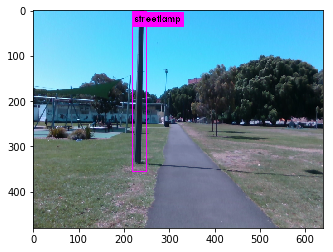

437

In [6]:

#cv_image = bridge.imgmsg_to_cv2(detectimg[2], desired_encoding="passthrough")
plt.imshow(cv2.cvtColor(detected_images[2], cv2.COLOR_BGR2RGB))

plt.show()

#cv2.imshow("Image window", cv_image)
#cv2.waitKey(0) 
#cv2.destroyWindow()

#cv_image

yolosize

In [7]:
#BRING DATA TO ENCODER TIME

imureal_time=imureal_time-encoder_time[0]
yolo_time=yolo_time-encoder_time[0]
image_time=image_time-encoder_time[0]


encoder_time=encoder_time-encoder_time[0]

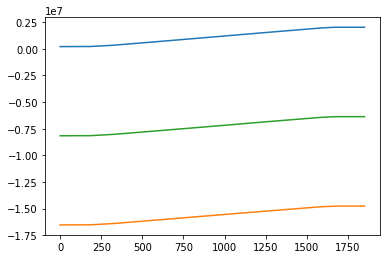

In [8]:
x=0
y=0
sign_x=0
sign_y=0

diffarray=np.array([])

for x in range(1,encoder_x.size-1):
    
    diff=encoder_x[x]-encoder_x[x-1]

    if abs(diff) > 16770000:
              
        sign_x=1
        changevalx=encoder_x[x-1]
        encoder_x[x]=encoder_x[x]+changevalx
        print changevalx    
        
    if sign_x==1:
    
        encoder_x[x+1]=encoder_x[x+1]+changevalx

        
for y in range(1,encoder_y.size-1):
    
    
    diff=encoder_y[y]-encoder_y[y-1]
    diffarray=np.append(diffarray,diff)

    if abs(diff) > 16770000:
              
        sign_y=1
        changevaly=diff
        encoder_y[y]=encoder_y[y]-changevaly   
        print changevaly
        
    if sign_y==1:
    
        encoder_y[y+1]=encoder_y[y+1]-changevaly

encoder_mean=(encoder_x-encoder_y)/2
encoder_y=-encoder_y

encoderdata={'encoder_seq':encoder_seq, 'encoder_time':encoder_time, 'encoder_x':encoder_x, 'encoder_y':encoder_y, 'encoder_mean':encoder_mean}
encoder_df = pd.DataFrame(encoderdata, columns=['encoder_seq','encoder_time','encoder_x','encoder_y','encoder_mean'])
#print encoder_df

plt.plot(encoder_x)
plt.plot(encoder_y)
plt.plot(encoder_df.loc[:,'encoder_mean'])

yolodata={'yolo_seq':yolo_seq, 'yolo_time':yolo_time,'image_seq':image_seq, 'image_time':image_time,'bounding_box':bounding_box}
yolo_df = pd.DataFrame(yolodata, columns=['yolo_seq','yolo_time','image_seq','image_time','bounding_box'])
#print yolo_df



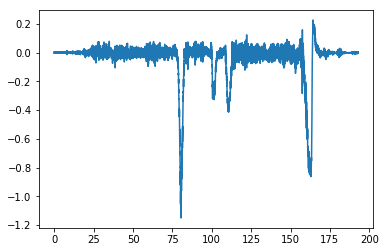

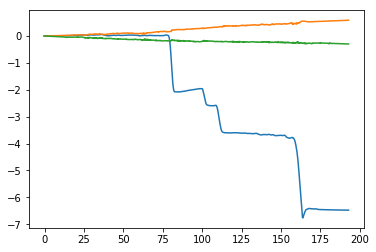

In [9]:
#INTEGRATING IMU DATA

imureal_angvZ=imureal_angvZ-imureal_angvZ[0]
imureal_angvX=imureal_angvX-imureal_angvX[0]
imureal_angvY=imureal_angvY-imureal_angvY[0]

plt.figure(1)
plt.plot(imureal_time,imureal_angvZ)
thetaZ=integrate.cumtrapz(imureal_angvZ,np.float64(imureal_time),initial=0)
thetaX=integrate.cumtrapz(imureal_angvX,np.float64(imureal_time),initial=0)
thetaY=integrate.cumtrapz(imureal_angvY,np.float64(imureal_time),initial=0)

plt.figure(2)
plt.plot(imureal_time,thetaZ)
plt.plot(imureal_time,thetaX)
plt.plot(imureal_time,thetaY)

imudata={'imureal_time':imureal_time, 'imureal_angvZ':imureal_angvZ, 'thetaZ':thetaZ}
imu_df = pd.DataFrame(imudata,columns=['imureal_time','imureal_angvZ','thetaZ'])
#print imu_df


In [10]:
#LOAD TO ARRAYS

mean_enc=np.array([encoder_df['encoder_mean']])
enc_time=np.array([encoder_df['encoder_time']])
imu_time=np.array([imu_df['imureal_time']])
fin_theta=np.array([imu_df['thetaZ']])

In [11]:
start = time.time()

dist=0
i=0

encXcalib=6.608284615932709e-05;
encYcalib=6.603486193757895e-05;
mean_calib=np.mean([encXcalib,encYcalib])

enc_dist=np.array([])
angles=np.array([])
anglesX=np.array([])
anglesY=np.array([])
mean_theta=np.array([])
mean_thetaX=np.array([])
mean_thetaY=np.array([])
mean_enctime=np.array([])

imureal_time=imureal_time-encoder_time[0]

encsize=encoder_mean.size

search_start=0
enciter=1

for timevals in imu_time[0]:
        
    if enciter < encsize:
    
        if timevals <= enc_time[0][enciter]:
           
            angles=np.append(angles,fin_theta[0][i])
            
            anglesX=np.append(anglesX,thetaX[i])
            anglesY=np.append(anglesY,thetaY[i])
            

        else:

            dist=(mean_enc[0,enciter]-mean_enc[0,(enciter-1)])*mean_calib
            
            enc_dist=np.append(enc_dist,dist)
            
            mean_enctime=np.append(mean_enctime,((enc_time[0][enciter]+enc_time[0][enciter-1])/2))

            mean_angle=angles.mean()
            mean_angleX=anglesX.mean()
            mean_angleY=anglesY.mean()
            
    

            if math.isnan(mean_angle):
                mean_theta=np.append(mean_theta,mean_theta[enciter-2])
                mean_thetaX=np.append(mean_thetaX,mean_thetaX[enciter-2])
                mean_thetaY=np.append(mean_thetaY,mean_thetaY[enciter-2])
            else:       
                mean_theta=np.append(mean_theta,mean_angle)
                mean_thetaX=np.append(mean_thetaX,mean_angleX)
                mean_thetaY=np.append(mean_thetaY,mean_angleY)

            enciter=enciter+1
            angles=np.array([])
            anglesX=np.array([])
            anglesY=np.array([])
    
    
    i=i+1    
    
    
mean_theta=-mean_theta
end = time.time()
print 'Completed in: ',end-start  

Completed in:  0.388099908829


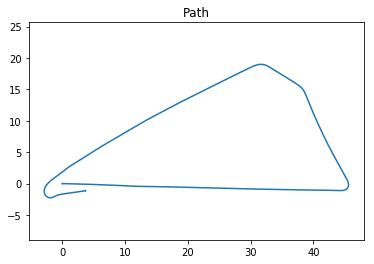

In [12]:
#mean_theta=mean_theta-mean_theta[0]
#plt.rcParams['figure.figsize'] = [50,50]

dx=np.multiply(enc_dist,np.cos(mean_theta))
dy=np.multiply(enc_dist,np.sin(mean_theta))
Xd=0
Yd=0

X_pos=np.array([])
Y_pos=np.array([])


for num in range(0,encsize-1):
    
    Xd=Xd+dx[num]
    Yd=Yd+dy[num]
    
    X_pos=np.append(X_pos,Xd)
    Y_pos=np.append(Y_pos,Yd)

    

plt.plot(X_pos,Y_pos)
plt.axis('equal')
plt.title('Path')
datacursor()
plt.show()


odomdata={'mean_enctime':mean_enctime,'enc_dist':enc_dist,'mean_theta':mean_theta, 'X_pos':X_pos, 'Y_pos':Y_pos}
odom_df = pd.DataFrame(odomdata,columns=['mean_enctime','enc_dist','mean_theta', 'X_pos','Y_pos'])

In [13]:
x_interp=interp1d(np.float64(mean_enctime), X_pos, kind='cubic')
y_interp=interp1d(np.float64(mean_enctime), Y_pos, kind='cubic')
mean_theta_interp=interp1d(np.float64(mean_enctime), mean_theta, kind='cubic')
mean_thetaX_interp=interp1d(np.float64(mean_enctime), mean_thetaX, kind='cubic')
mean_thetaY_interp=interp1d(np.float64(mean_enctime), mean_thetaY, kind='cubic')

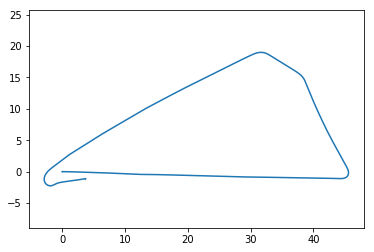

In [14]:
plt.plot(x_interp(np.float64(mean_enctime)),y_interp(np.float64(mean_enctime)))
plt.axis('equal')
plt.show()

In [15]:
lamp_dimensions=np.array([])
lamp_times=np.array([])
yolo_index=np.array([])
lamp_boxes=pd.DataFrame()
#yolo_df=yolo_df[2:]

'''
x=1

ind=0
for key,value in yolo_df.iteritems():
   
    if key=='bounding_box':
        for detects in value:
               
            for obj in detects:
                   if obj.Class=='streetlamp':
        
                        lamp_boxes=lamp_boxes.append(yolo_df.iloc[ind,:],ignore_index=True)
                        #print yolo_df.iloc[ind,:]
                
                        x=x+1
                       
            ind=ind+1
'''            


for row_index,row in yolo_df.iterrows():
    
        for obj in row[4]:
             if obj.Class=='streetlamp':
                if row[3]>mean_enctime[0] and row[3]<mean_enctime[-1]:
                    lamp_dimensions=np.append(lamp_dimensions,[obj.xmin,obj.ymin,obj.xmax,obj.ymax])
                    lamp_times=np.append(lamp_times,row[3])
                    yolo_index=np.append(yolo_index, row[0])                 
                    
                   
                
lamp_dimensions=np.reshape(lamp_dimensions, (lamp_dimensions.size/4, 4))                  

In [16]:
#detections=437
#Street lamps=524
yolo_df


yolo_seq         yolo_time  image_seq     image_time  \
0         0.0  244501.326802209      101.0    1.411729226   
1         1.0  244501.597630573      112.0    1.783014026   
2         2.0  244501.867719430      115.0    1.881631690   
3         3.0  244502.153476327      124.0    2.184337098   
4         4.0  244502.423384199      126.0    2.258292650   
5         5.0  244502.717291866      136.0    2.588431466   
6         6.0  244502.987852930      138.0    2.657294346   
7         7.0  244503.248405075      147.0    2.961715978   
8         8.0  244503.520749838      149.0    3.029471658   
9         9.0  244503.799882542      158.0    3.337239818   
10       10.0  244504.081156146      162.0    3.462968330   
11       11.0  244504.339077272      169.0    3.699171626   
12       12.0  244504.630000917      175.0    3.901946410   
13       13.0  244504.883261319      180.0    4.067354122   
14       14.0  244505.152056930      186.0    4.267084394   
15       15.0  244505.427894577      191.0    4.438821834   
16       16.0  244505.698350290      199.0    4.704441610   
17       17.0  244505.973971309      202.0    4.811746954   
18       18.0  244506.243849790      203.0    4.859186570   
19       19.0  244506.509660444      206.0    4.943499786   
20       20.0  244506.778327718      208.0    5.007470122   
21       21.0  244507.053249284      217.0    5.315381066   
22       22.0  244507.372477911      230.0    5.746338826   
23       23.0  244507.638697404      240.0    6.081564522   
24       24.0  244507.895759421      243.0    6.181951850   
25       25.0  244508.167650625      251.0    6.455402762   
26       26.0  244508.446037134      254.0    6.551993674   
27       27.0  244508.719918568      264.0    6.891279370   
28       28.0  244509.004562700      267.0    6.989588266   
29       29.0  244509.265589448      275.0    7.261610346   
..        ...               ...        ...            ...   
407     407.0  244685.203715265     2867.0  180.412964938   
408     408.0  244685.472951352     2869.0  180.547217258   
409     409.0  244685.766246230     2876.0  181.017481098   
410     410.0  244686.030406032     2883.0  181.476805866   
411     411.0  244686.319175804     2891.0  182.026723722   
412     412.0  244686.860803019     2898.0  182.480148682   
413     413.0  244687.393624549     2905.0  182.952118250   
414     414.0  244687.662428960     2909.0  183.231552458   
415     415.0  244687.934603239     2911.0  183.358676906   
416     416.0  244688.206856747     2917.0  183.760758730   
417     417.0  244688.480462887     2920.0  183.969765578   
418     418.0  244688.768371051     2925.0  184.298023658   
419     419.0  244689.041272901     2928.0  184.508703754   
420     420.0  244689.308932979     2934.0  184.911102794   
421     421.0  244689.586826756     2937.0  185.124160298   
422     422.0  244690.138143079     2944.0  185.590655786   
423     423.0  244690.412909368     2947.0  185.791138666   
424     424.0  244690.693304380     2950.0  186.071350058   
425     425.0  244690.962324853     2950.0  186.071350058   
426     426.0  244692.344938600     2987.0  187.490622730   
427     427.0  244692.882982660     2995.0  188.030771082   
428     428.0  244693.152860996     2998.0  188.232475082   
429     429.0  244693.974404738     3011.0  189.115737866   
430     430.0  244694.248925542     3016.0  189.438782922   
431     431.0  244694.530097162     3020.0  189.715063370   
432     432.0  244695.355451877     3031.0  190.530024970   
433     433.0  244695.623022159     3032.0  190.580404522   
434     434.0  244696.162531476     3034.0  190.716459082   
435     435.0  244696.435087251     3039.0  191.048883562   
436     436.0  244698.094092663     3066.0  192.912485322   

                                          bounding_box  
0    [Class: "streetlamp"\nprobability: 0.593103706...  
1    [Class: "streetlamp"\nprobability: 0.941821217...  
2    [Class: "streetlamp"\nprobability: 0.889244675

In [17]:
def getyolobearing(times, dimensions, x_interp, y_interp):
    
    h_fov=np.deg2rad(69.4)
    h_width=640
    centerX=h_width/2
    
    rad_per_pix=h_fov/h_width

    centroids=np.zeros((dimensions.shape[0],2))
    bearings=np.zeros(dimensions.shape[0])
    gradients=np.zeros(dimensions.shape[0])
    intercepts=np.zeros(dimensions.shape[0])
    
  
    centroids[:,0]=(dimensions[:,0]+dimensions[:,2])/2
    centroids[:,1]=(dimensions[:,1]+dimensions[:,3])/2
    
    bearings=(centroids[:,0]-centerX)*rad_per_pix
    gradients=np.tan(bearings)
    
    #intercepts=y_interp(np.float64(times))-np.multiply(gradients, x_interp(np.float64(times)))
    
    return bearings,centroids

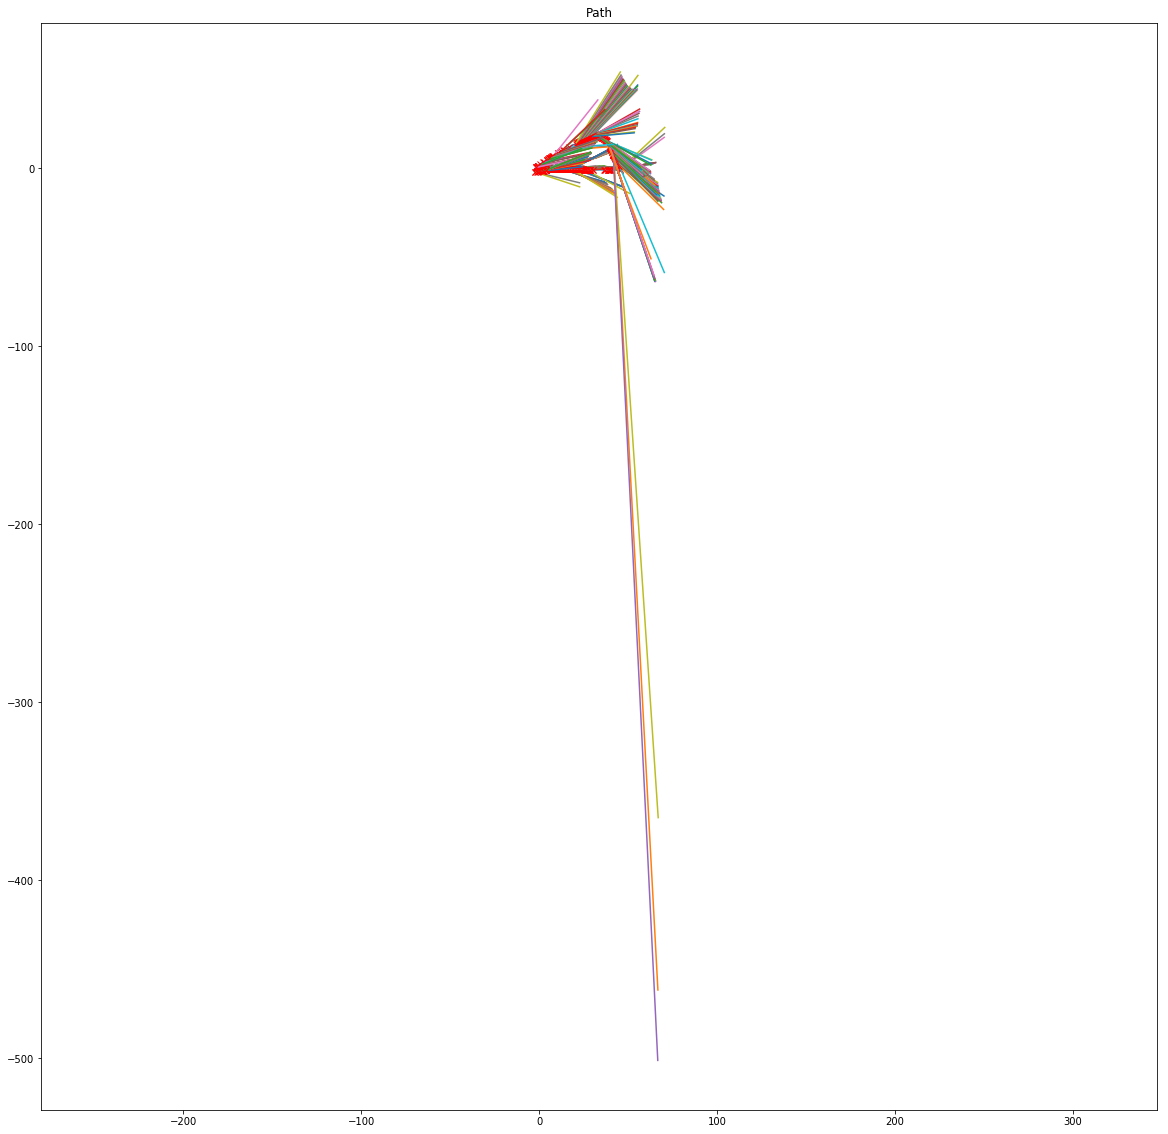

In [24]:
bearings,centroids=getyolobearing(lamp_times,lamp_dimensions,x_interp, y_interp) 

plt.rcParams['figure.figsize'] = [20,20]
plt.plot(X_pos,Y_pos)
plt.axis('equal')
plt.title('Path')
#plt.plot(x_interp(np.float64(bench_times)),y_interp(np.float64(bench_times)),'rx')

scooter_LX=np.array([])
scooter_LY=np.array([])
scooter_LTHETA=np.array([])
scooter_LTHETAX=np.array([])
scooter_LTHETAY=np.array([])

for i in range(0,lamp_times.size):
#for i in range(0,1885):
    
    samp_time=lamp_times[i]
    scooter_x=x_interp(np.float64(samp_time))
    scooter_y=y_interp(np.float64(samp_time))
    scooter_theta=mean_theta_interp(np.float64(samp_time))
    scooter_thetaX=mean_thetaX_interp(np.float64(samp_time))
    scooter_thetaY=mean_thetaY_interp(np.float64(samp_time))
    
    
    scooter_LX=np.append(scooter_LX,scooter_x)
    scooter_LY=np.append(scooter_LY,scooter_y)
    scooter_LTHETA=np.append(scooter_LTHETA,scooter_theta)
    scooter_LTHETAX=np.append(scooter_LTHETAX,scooter_thetaX)
    scooter_LTHETAY=np.append(scooter_LTHETAY,scooter_thetaY)
    
    xplotz=np.linspace(0, 25, num=25)
    
    yplotz=np.multiply(xplotz, np.tan(np.add(scooter_theta,-bearings[i])))
    
    #print np.tan((np.add(scooter_theta,-bearings[i])))
    #print np.add(scooter_theta,-bearings[i])
    
    plt.plot((xplotz+scooter_x),(yplotz+scooter_y))
    plt.plot(scooter_x,scooter_y,'rx')    
    
plt.show()

lampdata={'yolo_index':yolo_index,'lamp_times':lamp_times,'bearings':bearings,'scooter_LX':scooter_LX, 'scooter_LY':scooter_LY, 'scooter_LTHETA':scooter_LTHETA, 'centroid_x':centroids[:,0],'centroid_y':centroids[:,1],'scooter_LTHETAX':scooter_LTHETAX,'scooter_LTHETAY':scooter_LTHETAY}
lampdata_df = pd.DataFrame(lampdata,columns=['yolo_index','lamp_times','bearings','scooter_LX', 'scooter_LY','scooter_LTHETA','centroid_x','centroid_y','scooter_LTHETAX','scooter_LTHETAY'])

In [25]:
#SAVE DATA FOR MATLAB

odom_df.to_csv('./csv_data/'+filename + '-odom.csv')
lampdata_df.to_csv('./csv_data/'+filename + '-lampdata.csv')

In [20]:
i=1
for img in detected_images:

    cv2.imwrite('./img_data/'+ filename + "-"+ str(i) + ".jpg",img) #[int(cv2.IMWRITE_JPEG_QUALITY), 100]) 
    
    i=i+1

In [21]:
lamp_boxes

Empty DataFrame
Columns: []
Index: []

In [26]:
lampdata_df

yolo_index     lamp_times  bearings  scooter_LX    scooter_LY  \
0           0.0    1.411729226 -0.161817   -0.000033  3.768098e-08   
1           1.0    1.783014026 -0.161817   -0.000185  4.431609e-07   
2           2.0    1.881631690 -0.161817   -0.000225  5.677632e-07   
3           3.0    2.184337098 -0.161817   -0.000183  4.319115e-07   
4           4.0    2.258292650 -0.162763   -0.000258  7.042242e-07   
5           5.0    2.588431466 -0.162763   -0.000758  2.645358e-06   
6           6.0    2.657294346 -0.162763   -0.000826  2.933564e-06   
7           7.0    2.961715978 -0.162763   -0.001050  3.926517e-06   
8           8.0    3.029471658 -0.162763   -0.001100  4.159105e-06   
9           9.0    3.337239818 -0.162763   -0.001139  4.354124e-06   
10         10.0    3.462968330 -0.162763   -0.001176  4.545376e-06   
11         11.0    3.699171626 -0.162763   -0.001255  4.978377e-06   
12         12.0    3.901946410 -0.162763   -0.001316  5.338615e-06   
13         13.0    4.067354122 -0.162763   -0.001437  6.056940e-06   
14         14.0    4.267084394 -0.162763   -0.001592  7.018202e-06   
15         15.0    4.438821834 -0.162763   -0.001873  8.771667e-06   
16         16.0    4.704441610 -0.162763   -0.002104  1.025689e-05   
17         17.0    4.811746954 -0.161817   -0.001994  9.511290e-06   
18         18.0    4.859186570 -0.162763   -0.001881  8.735507e-06   
19         19.0    4.943499786 -0.161817   -0.001606  6.827953e-06   
20         20.0    5.007470122 -0.161817   -0.001451  5.733027e-06   
21         21.0    5.315381066 -0.162763   -0.001613  6.898909e-06   
22         22.0    5.746338826 -0.161817   -0.001853  8.621772e-06   
23         23.0    6.081564522 -0.162763   -0.001992  9.722489e-06   
24         24.0    6.181951850 -0.162763   -0.001869  8.722494e-06   
25         25.0    6.455402762 -0.161817   -0.001859  8.647590e-06   
26         26.0    6.551993674 -0.162763   -0.001999  9.820288e-06   
27         27.0    6.891279370 -0.161817   -0.003695  2.410193e-05   
28         28.0    6.989588266 -0.161817   -0.004050  2.715214e-05   
29         29.0    7.261610346 -0.161817   -0.003883  2.564159e-05   
..          ...            ...       ...         ...           ...   
492       406.0  180.338588554 -0.191152    3.750570 -1.122906e+00   
493       407.0  180.412964938 -0.191152    3.750445 -1.122929e+00   
494       408.0  180.547217258 -0.191152    3.750277 -1.122959e+00   
495       409.0  181.017481098 -0.192098    3.751427 -1.122753e+00   
496       410.0  181.476805866 -0.192098    3.751393 -1.122760e+00   
497       411.0  182.026723722 -0.192098    3.750673 -1.122891e+00   
498       412.0  182.480148682 -0.191152    3.750654 -1.122895e+00   
499       413.0  182.952118250 -0.192098    3.750727 -1.122881e+00   
500       414.0  183.231552458 -0.191152    3.750725 -1.122882e+00   
501       415.0  183.358676906 -0.191152    3.750769 -1.122874e+00   
502       416.0  183.760758730 -0.192098    3.750782 -1.122871e+00   
503       417.0  183.969765578 -0.191152    3.750714 -1.122884e+00   
504       418.0  184.298023658 -0.191152    3.750721 -1.122882e+00   
505       419.0  184.508703754 -0.192098    3.750721 -1.122882e+00   
506       420.0  184.911102794 -0.191152    3.750720 -1.122883e+00   
507       421.0  185.124160298 -0.191152    3.750700 -1.122886e+00   
508       422.0  185.590655786 -0.191152    3.750688 -1.122889e+00   
509       423.0  185.791138666 -0.192098    3.750688 -1.122889e+00   
510       424.0  186.071350058 -0.192098    3.750688 -1.122889e+00   
511       425.0  186.071350058 -0.192098    3.750688 -1.122889e+00   
512       426.0  187.490622730 -0.191152    3.750688 -1.122889e+00   
513       427.0  188.030771082 -0.191152    3.750656 -1.122895e+00   
514       428.0  188.232475082 -0.191152    3.750656 -1.122895e+00   
515       429.0  189.115737866 -0.191152    3.750656 -1.122895e+00   
516       430.0  189.438782922 -0.191152    3.750656 -1.122895e+00   
517       431.0